<h1 style="text-align: center;">Hit Analyzer</h1>
<h2 style="text-align: center;">By: Thomas Giewont, Shreyas Vaidya, and Thomas Varano</h2>

<br>
<h3 style="text-align: center;">Introduction</h3>
<p>Have you ever wondered about how a song performs once it releases, and how an audience feels about a song? When a song comes out, many events start to happen. An artist is always in anticipation of how a song will perform with their audience, and if they will like the song or not. People stream, buy, and listen to songs from different artists, and these metrics are what help popularize the artist. The one company that is in charge of keeping record of how each song performs is Billboard. Billboard charts can make the career of an artist. Artists that often reach into Billboard charts end up having popular music careers, earn money, and are able to continue to pursue what they love doing, making music. One specific chart, the “Billboard Hot 100” is a chart that began on August 4th, 1958 detailing the 100 most popular songs in the United States. This database is one of the most recognized databases in the world, and has created a massive ripple effect in the music industry in the United States.<br/><br/>
The “Billboard Hot 100” chart is the music industry standard chart for ranking a song and artist’s popularity. The chart, which is released weekly, gives the world an idea on how popular a song is based on three factors: sales, online streaming, and how much the song is played on the radio. Artists often find their fame through how their song performs in the Billboard Hot 100 charts. For example, “Drivers License” by Olivia Rodrigo ranked #1 on the Billboard Hot 100 for eight weeks in a row, one of the best songs to ever do so, and subsequently brought Olivia Rodrigo into the limelight and music fame.<br/><br/>
	While Rodrigo’s song is one example of a song reaching the Hot 100, there are many more examples of songs being successful. However, analyzing and predicting a song’s trends on the chart is difficult. This is what our project is based on. Given a song that was on the Hot 100, we will be able to predict and categorize how the song trended and performed on the Hot 100. <br/><br/>
	We chose to do this project because the three of us are avid music listeners and frequently discuss music with each other. When choosing a topic to write about, we quickly realized that most music trends revolve around the Billboard Hot 100. We wanted to see what the effect of this chart was, and how it directly impacted the song and artist’s success.<br/><br/>
	By gathering data on the Billboard Hot 100 from 2000-2019, we will be able to analyze trends of songs on the charts and use machine learning to create a model to predict other songs and how they will trend on the charts. This time period will also show us how streaming made an impact on the music industry during this time period.
</p>

<h3 style="text-align: center;">Imports and Data Setup</h3>

<p>
The libraries we are using for this project are Numpy, Matplotlib, SKLearn, JSON format, Math and Pandas. Below are the respective documentation for each library used in this project:<br/>
Numpy: https://numpy.org/doc/stable/ <br/>
Matplotlib: https://matplotlib.org/stable/contents.html <br/>
SKLearn: https://scikit-learn.org/stable/user_guide.html <br/>
JSON: https://www.json.org/json-en.html <br/>
Math: https://docs.python.org/3/library/math.html <br/>
Pandas: https://pandas.pydata.org/docs/ <br/><br/>

A large part of this project deals with DataFrames, which is a data structure in the Pandas library. This data structure is similar to a database, and is a two-dimensional and  heterogenous form of database. More information about specifically DataFrames can be found here: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html </p>

In [2]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import math
from sklearn.cluster import KMeans
import json

<h3 style="text-align: center;">Data Collection and Curation</h3>

<p>We retrieved our data from data.world, a website with databases for different topics. The Billboard Hot 100 chart data that we are using is between 8/2/1958 and 12/28/2019. However, for our initial analysis, we truncated the data to only 1/1/2000 and after. We also cleaned up the data, such as removing unnecessary columns, and renaming columns to be better interpreted.<br/><br/>
Our dataframe had 325,695 rows, indicating a weekly entry for a song. For example, if a song's chart "life" was eight weeks, there would be eight rows for the song (one for each week).<br/>
Data Link: https://data.world/kcmillersean/billboard-hot-100-1958-2017 </p>

In [41]:
df = pd.read_csv('https://query.data.world/s/aofqalvgkuabshmmlxm32rxk3t3yiq')

In [42]:
df = df.drop(columns=['url'])
df = df.rename(columns={'WeekID': 'week', 'Week Position': 'week_position', 'Song': 'song', 'Performer': 'performer', 'SongID': 'songid', 'Instance': 'instance', 'Previous Week Position': 'prev_week_position', 'Peak Position': 'peak_position', 'Weeks on Chart': 'weeks_on_chart'})

In [43]:
df = df.astype({"week": 'datetime64'})

In [44]:
df.columns.values

array(['week', 'week_position', 'song', 'performer', 'songid', 'instance',
       'prev_week_position', 'peak_position', 'weeks_on_chart'],
      dtype=object)

<p> After reading in the dataframe, the above result shows the names of the columns that were initially used. Since this is the raw information we were given, we still need to clean more items in the dataframe, shown below.</p>

In [45]:
# Because our dataset was large, we had to test our dataframe with songs after 2000. However, in this final version, we use all rows in the dataframe.
# df = df[df.week > pd.to_datetime(datetime.date(2000, 1, 1))]

In [46]:
# make a copy incase we fuck some data
dfcpy = df.copy()

In [47]:
# restore df
df = dfcpy.copy()

<h3 style="text-align: center;">Data Analysis</h3>

In [48]:
# dropping NaN values, except for prev_week_position (the song's first week has a prev_week_position of NaN)
df = df.dropna(subset=['week', 'week_position', 'song', 'performer', 'songid', 'instance', 'peak_position', 'weeks_on_chart'])
# peak_position is not used
df = df.drop(columns=['peak_position'])

In [49]:
# make dataframe to keep track of song-wide data

song_info = df.drop_duplicates(subset=['songid']).drop(columns=['week', 'week_position', 'instance', 'prev_week_position', 'weeks_on_chart']).set_index('songid')

<p>We create a new dataframe that is going to be used throughout the rest of the tutorial, and will be useful when doing machine learning analysis: song_info. For this specific cell, song_info is the same as the original dataframe, but with dropped columns that are unnecessary, and with ‘songid’ as the index. <br/><br/>
song_info is different from the original dataframe because every song represents a single row, instead of having an instance of the song per week. This allows us to use less space when describing something that is unique to the entire song. For example, the song's highest peak position. There are 29,154 rows in this dataframe, indicating that 29,154 songs were in the "Billboard Hot 100" during this time period.
</p>

<p>Below is a graph of a typical song that was on the Billboard Hot 100. The song we are using for this example is “Same Old Love” by Selena Gomez. The red line indicates the 10th position on the Billboard chart. As we can see, the song started off lower in the chart, between 40th and 50th. However, we can see that in two months, the song started to peak above 10th, ultimately reaching a peak of 5th early 2016. These trends of climbing and falling are what we will be primarily analyzing for this tutorial.</p>

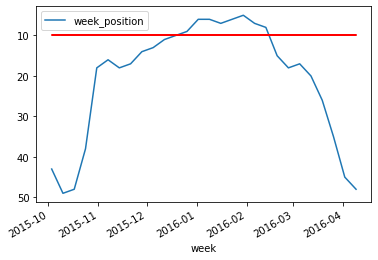

In [50]:
ax = plt.gca()
s = "Same Old LoveSelena Gomez"
df[df.songid == s].plot(x='week', y='week_position', ax = ax)
horiz_line_data = np.array([10 for i in range(len(df[df.songid == s]))])
plt.plot(df[df.songid == s].week, horiz_line_data, 'r') 
plt.gca().invert_yaxis()

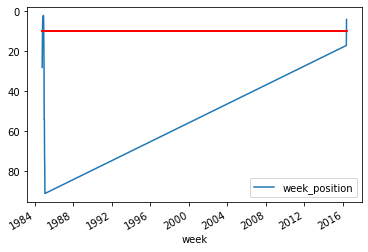

In [51]:
ax = plt.gca()
s = "Purple RainPrince And The Revolution"
df[df.songid == s].plot(x='week', y='week_position', ax = ax)
horiz_line_data = np.array([10 for i in range(len(df[df.songid == s]))])
plt.plot(df[df.songid == s].week, horiz_line_data, 'r') 
plt.gca().invert_yaxis()

<p>An interesting note (and outlier) when testing out different graphs was that certain artists rose in the Billboard charts while they were alive, and after they died. For example, Prince had songs rise into the chart while he was popular in the 1980s, and again after he died in 2016. We wanted to avoid this scenario as they interfered greatly with our predicition for the categorization of the songs. Therefore, we decided to remove any instances where a song gets popular two years later or more after its initial time on the chart.<br/><br/>
The graph above shows how a song, such as Purple Rain, will reach the chart long after a song debuts. We believe that this is not representative on how a song performed, so that is why we decided to get rid of songs that followed this pattern.
</p>

<p>This shows our predictive algorithm before we decided to remove these outlier entries. We will get into more detail about our categorization process later, but this shows how great of an affect these outliers had. Their tails were so large, they completely controlled the algorithm -- very little other data mattered due to how much they differed. This essentially only left groups 0 and 9 sufficiently populated. Though this data is interesting, it does not convey the information we wish to show for this tutorial, and is therefore skewing our predictions. By removing them, we leave ourselves with much cleaner, more distinct, and more representative categories.</p>
<img src='img/fig.png'>


In [52]:
for s in df.songid.unique():
    song_instances = df[df.songid == s].sort_values(by='week')

    # remove all instances of the song that are more than 2 years out from the previous time on the charts
    indxs = song_instances.index.values
    lastPoint = 0
    for i in range(1, len(indxs)):
        if (song_instances.loc[indxs[i]].week - song_instances.loc[indxs[lastPoint]].week).days / 365 > 2: 
            df = df.drop(index=indxs[i])
            song_instances = song_instances.drop(index=indxs[i])
        else: 
            lastPoint += 1

<p>Since we had a large amount of data, we decided to shorten the dataframe size to only include songs that peaked at position 10 or above. We also believe that this restricts our findings to be more specific to songs that achieve higher levels of success. For example, we did not want to include a song that would have only reached position 100 and left the charts as this was not the level of popularity we were focusing on.</p>

In [53]:
# get the absolute peak for each song
for s in list(song_info.index.values): 
    song_info.at[s, 'peak'] = min(df[df.songid == s].week_position.unique())

df = df[[(song_info.loc[r.songid].peak <= 10) for _, r in df.iterrows()]]
song_info = song_info[song_info.peak <= 10]


<p>For most of the rest of the analysis, we will be focusing on four major control points: the starting week on the chart, the start of the “peak”, the end of the “peak”, and the ending week on the chart. There are many definitions and interpretations of “peak”, but for this tutorial we are going to focus on the <i>longest period of time where a song was above or equal to the 10th position on the chart.</i></p>

In [54]:
for s in df.songid.unique():

    song_instances = df[df.songid == s].sort_values(by='week')

    if len(song_instances[song_instances.week_position <= 10].week) != 0: 
        week = 1
        
        # get all peaks and their weeks
        # inflection points of graph in form: 
        # tuple (date, begin), where begin is true if the inflection point is beginning a hot spell
        inflections = []
        longest_peak = []

        # if the first week is already in the top 10
        if song_instances.iloc[0].week_position <= 10: 
            inflections.append((song_instances.iloc[0].week, True))


        for i in range(1, len(song_instances)): 
                
            if song_instances.iloc[i].week_position <= 10 and song_instances.iloc[i - 1].week_position > 10: 
                # this is for grace period
                if i > 1 and song_instances.iloc[i-2].week_position <= 10: 
                    # remove the last ending guy
                        inflections.remove(inflections[len(inflections) - 1])
                else: 
                    # if not beginning after a grace period, 
                    inflections.append((song_instances.iloc[i].week, True))
            elif song_instances.iloc[i].week_position > 10 and song_instances.iloc[i - 1].week_position <= 10:
                inflections.append((song_instances.iloc[i - 1].week, False))
   
        # if the song finished in the top 10 and dropped off the charts
        if song_instances.iloc[len(song_instances) - 1].week_position <= 10: 
            inflections.append((song_instances.iloc[len(song_instances) - 1].week, False))

        for i in range(0, len(inflections)-1):
            longest_date = datetime.timedelta(0)
            if len(inflections) == 0 or len(inflections) == 1:
                longest_peak = inflections
            else:
                if inflections[i][1] is True and inflections[i+1][1] is False:
                    if inflections[i+1][0] - inflections[i][0] >= longest_date:
                        longest_date = inflections[i+1][0] - inflections[i][0]
                        longest_peak = []
                        longest_peak.append(inflections[i])
                        longest_peak.append(inflections[i+1])

            # longest peak is relevant peak we care about

        song_info.loc[s, 'start_week'] = min(song_instances.week)
        song_info.loc[s, 'end_week'] = max(song_instances.week)
        song_info.loc[s, 'start_peak'] = longest_peak[0][0]
        song_info.loc[s, 'end_peak'] = longest_peak[1][0]
        
                

<p>
One song in particular, “All I Want for Christmas” by Mariah Carey, created a surprising trend when analyzing the data from the Billboard chart. This song tops the charts at the same time every year and then immediately drops out of the chart. This is largely because this song is played during the winter holidays every year as a song to get people in the spirit of the holidays. This song is also an outlier in our data, and most other holiday songs followed the same trend. Another outlier in the graph was that some songs peaked in the Billboard charts for only one week, and immediately fell after.<br/><br/>
This cell creates three new columns in the ‘song_info’ dataframe. The ‘weeks_to_hot’ column calculates the number of weeks it took for a song to reach their peak. The ‘weeks_hot’ column calculates the duration of the peak (how long the song was ‘hot’). ‘tail_weeks’ calculates the number of weeks it took a song to fall off the charts after reaching the peak.
</p>


In [55]:
# make weeks to hot and weeks hot

for i, r in song_info.iterrows(): 
    song_info.loc[i, 'weeks_to_hot'] = (r.start_peak - r.start_week).days / 7
    song_info.loc[i, 'weeks_hot'] = (r.end_peak - r.start_peak).days / 7 + 1
    song_info.loc[i, 'tail_weeks'] = (r.end_week - r.end_peak).days / 7

song_info = song_info.astype({"weeks_to_hot": 'float', "weeks_hot": 'float', "tail_weeks": 'float'})


<p>The cell below is the start of using machine learning and creating a prediction on how the song will perform in the charts. We are using an unsupervised learning model, which helps to find patterns from data that is untagged. This means that the model can work on its own to detect different patterns in our data. Using unsupervised learning is especially useful in this circumstance because using the unsupervised learning model helps us to detect unknown patterns from lots of data points. More information about unsupervised learning can be found here: https://www.ibm.com/cloud/learn/unsupervised-learning<br/></p>
<h4>Hypothesis:</h4>
<p>Having looked at different trends in the cycle of songs in a Billboard chart, we believe that songs’ lives on the charts can be categorized into five distinct groups.<br/><br/>
The ‘train’ dataframe is the same as the ‘song_info’ dataframe, but with certain columns. We will use this dataframe to train our prediction model and help to categorize the songs. These columns are what we will use to categorize the songs. NOTE TOM G EXPAND WHY WE CHOSE COLUMNS WE DID<br/>

In this cell, we create a new column called ‘rel_week’, which defines how songs are doing across time relative to each other. rel_week is a standarized week column showing the data points relative to the week that the songs debuted on the chart. This column will be useful in the future for machine learning.</p>

In [56]:
for i, r in df.iterrows(): 
    df.at[i, 'rel_week'] = (r.week - song_info.loc[r.songid, 'start_week']).days / 7

<p>In the below graph, we can see the “lifecycle” of several random songs and how they do on the charts over time. For this graph, we used ten songs. This overlay shows that many songs follow the same trends.</p>

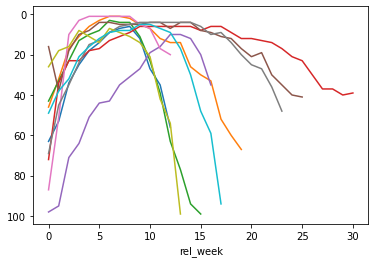

In [57]:
# a couple graphs to make pretty and look at
sngs = song_info.sample(n=10).index.values
ax = plt.gca()
tmp = df.sort_values(by='week')
for s in sngs: 
    tmp[tmp.songid == s].plot(x='rel_week', y='week_position', ax=ax)
plt.gca().invert_yaxis()
ax.get_legend().remove()
plt.show()

<p>This cell creates more columns in the ‘song_info’ dataframe that will be used for calculations in our prediction model. Below is a summary of each new column:<br/>
‘time_at_top_ten’ calculates the amount of time a song remains in the top ten, across the song’s entire life on the charts.<br/>
‘climb_slope’ calculates the slope of the climb of the song until it reaches its peak.<br/>
‘tail_slope’ is the same as ‘climb_slope’ but for the tail of the song, after it has reached its last week of the peak.<br/>
‘avg_position’ gives the average position of the song in the charts for all weeks that it was on the Billboard charts.<br/>
‘weeks_on_chart’ gives all the weeks that a song was on a chart.<br/>
‘instance’ is the amount of times a song has been on the chart.
</p>

In [58]:
# More data points 

for s in df.songid.unique(): 
    song_inst = df[df.songid == s]

    # time above 10 total
    song_info.at[s, 'time_at_top_10'] = len(song_inst[song_inst.week_position <= 10])

    # slope of the climb
    # abs(start_peak position - start_week position)
    pos_climbed = abs(int(song_inst[song_inst.week == song_info.loc[s, 'start_peak']].week_position) - int(song_inst[song_inst.week == song_info.loc[s, 'start_week']].week_position))
    # if the song started on the chart, make the slope -1. else, make it (how many positions it climbed) / (how long the climb was)
    song_info.loc[s, 'climb_slope'] = -1 if song_info.loc[s, 'weeks_to_hot'] == 0 else (pos_climbed/song_info.loc[s, 'weeks_to_hot'])

    # slope of the tail (-1 if it just fell off the charts)
    # abs(end_peak position - end_week position)
    pos_lost = abs(int(song_inst[song_inst.week == song_info.loc[s, 'end_peak']].week_position) - int(song_inst[song_inst.week == song_info.loc[s, 'end_week']].week_position))
    song_info.loc[s, 'tail_slope'] = -1 if song_info.loc[s, 'tail_weeks'] == 0 else (pos_lost/song_info.loc[s, 'tail_weeks'])

    # average value
    song_info.at[s, 'avg_position'] = song_inst.week_position.mean()

    # weeks on chart
    song_info.at[s, 'weeks_on_chart'] = max(song_inst.weeks_on_chart)

    # instance
    song_info.at[s, 'instance'] = max(song_inst.instance)
song_info



,song,performer,peak,start_week,end_week,start_peak,end_peak,weeks_to_hot,weeks_hot,tail_weeks,time_at_top_10,climb_slope,tail_slope,avg_position,weeks_on_chart,instance
songid,,,,,,,,,,,,,,,,
StillBill Anderson,Still,Bill Anderson,8.0,1963-04-13,1963-07-20,1963-06-08,1963-06-22,8.0,3.0,4.0,3.0,11.375000,7.000000,34.066667,15.0,1.0
Saturday NightBay City Rollers,Saturday Night,Bay City Rollers,1.0,1975-10-11,1976-01-31,1975-12-06,1976-01-10,8.0,6.0,3.0,6.0,9.500000,15.333333,27.588235,17.0,1.0
Pop MuzikM,Pop Muzik,M,1.0,1979-08-11,1980-01-19,1979-10-06,1979-12-01,8.0,9.0,7.0,9.0,6.625000,12.857143,25.208333,24.0,1.0
CarrieEurope,Carrie,Europe,3.0,1987-08-01,1987-12-05,1987-09-26,1987-10-24,8.0,5.0,6.0,5.0,8.125000,15.000000,35.736842,19.0,1.0
CasanovaLevert,Casanova,Levert,5.0,1987-08-15,1987-12-12,1987-10-10,1987-10-31,8.0,4.0,6.0,4.0,10.000000,15.166667,34.666667,18.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
You Keep Me Hangin' OnThe Supremes,You Keep Me Hangin' On,The Supremes,1.0,1966-10-29,1967-01-14,1966-11-12,1966-12-17,2.0,6.0,4.0,6.0,30.500000,11.250000,17.750000,12.0,1.0
You Keep Me Hangin' OnThe Vanilla Fudge,You Keep Me Hangin' On,The Vanilla Fudge,6.0,1967-07-08,1968-09-28,1968-08-31,1968-08-31,60.0,1.0,4.0,1.0,1.333333,4.250000,39.470588,17.0,2.0
You Learn/You Oughta KnowAlanis Morissette,You Learn/You Oughta Know,Alanis Morissette,6.0,1996-07-27,1997-02-15,1996-09-07,1996-09-28,6.0,4.0,20.0,7.0,0.666667,1.550000,22.433333,30.0,1.0


<p>Below are graphs that detail the new ‘song_info’ column values and how they calculate for different songs. Another column was added as well: ‘jump’. This column calculates how much a song increased between weeks, and the histogram details for each song.</p>

In [59]:
df.insert(loc=len(df.columns), column='jump', value=[r.week_position - r.prev_week_position for _, r in df.iterrows()])

array([<AxesSubplot:title={'center':'jump'}>], dtype=object)

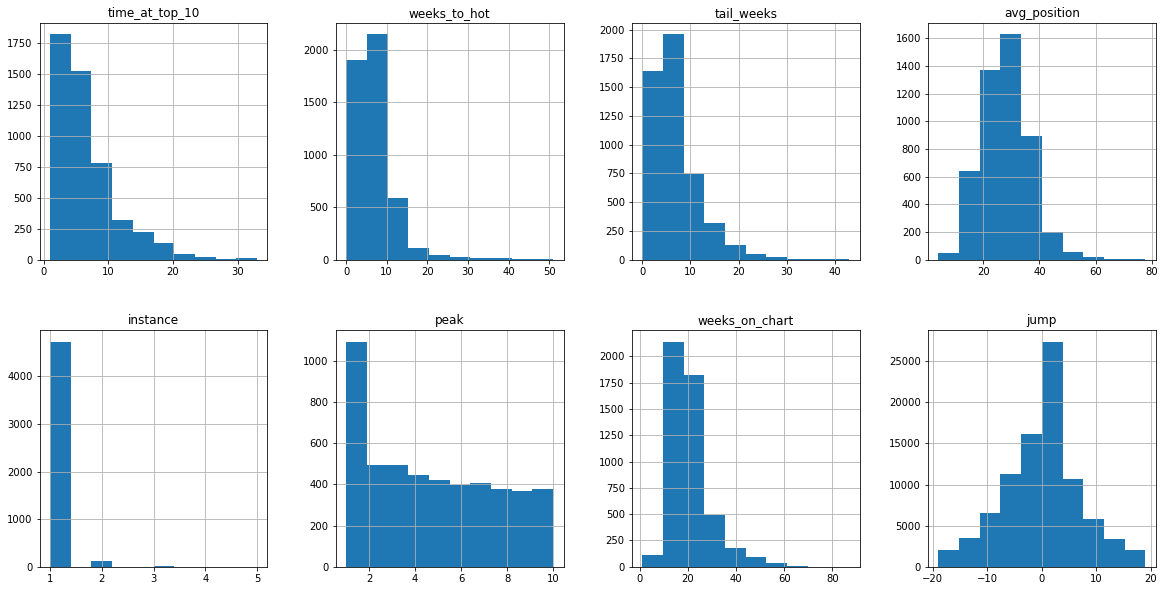

In [60]:
fig, axs = plt.subplots(2,4,figsize=(20,10))

song_info.hist('time_at_top_10', ax=axs[0, 0])
song_info[song_info.weeks_to_hot < 52].hist('weeks_to_hot', ax=axs[0, 1])
song_info[song_info.tail_weeks < 52].hist('tail_weeks', ax=axs[0, 2])
song_info.hist('avg_position', ax=axs[0, 3])
song_info.hist('instance', ax=axs[1, 0])
song_info.hist('peak', ax=axs[1, 1])
song_info.hist('weeks_on_chart', ax=axs[1, 2])
df[abs(df.jump) < 20].hist('jump', ax=axs[1, 3])


<p>For this model, we are using the SKLearn library, and creating the model using “KMeans”. This part of SKLearn is a form of clustering data, which creates the clusters by organizing data into k clusters around the nearest mean to each cluster. More information about KMeans can be found here: https://stanford.edu/~cpiech/cs221/handouts/kmeans.html In the next cell, we set a random state for our prediction model that will be consistent for the rest of the tutorial. We keep the same random state as well to make sure that the groups remain the same throughout.<br/><br/>

For the ‘train’ dataframe, we take each song and assign them to a group from the categories listed in the hypothesis. The groups were determined through the KMeans clustering algorithm.

TOM G WHY DID WE USE KMEANS AND EXPLAIN VARIABLE MEANINGS??
</p>

In [76]:
# SAVED HERE
df.to_csv("dfSave.csv")
song_info.to_csv("songInfoSave.csv")

In [3]:
# READ HERE 
df = pd.read_csv('dfSave.csv')
song_info = pd.read_csv('songInfoSave.csv').set_index('songid')

In [4]:
song_info

,song,performer,peak,start_week,end_week,start_peak,end_peak,weeks_to_hot,weeks_hot,tail_weeks,time_at_top_10,climb_slope,tail_slope,avg_position,weeks_on_chart,instance,group
songid,,,,,,,,,,,,,,,,,
StillBill Anderson,Still,Bill Anderson,8.0,1963-04-13,1963-07-20,1963-06-08,1963-06-22,8.0,3.0,4.0,3.0,11.375000,7.000000,34.066667,15.0,1.0,9
Saturday NightBay City Rollers,Saturday Night,Bay City Rollers,1.0,1975-10-11,1976-01-31,1975-12-06,1976-01-10,8.0,6.0,3.0,6.0,9.500000,15.333333,27.588235,17.0,1.0,2
Pop MuzikM,Pop Muzik,M,1.0,1979-08-11,1980-01-19,1979-10-06,1979-12-01,8.0,9.0,7.0,9.0,6.625000,12.857143,25.208333,24.0,1.0,5
CarrieEurope,Carrie,Europe,3.0,1987-08-01,1987-12-05,1987-09-26,1987-10-24,8.0,5.0,6.0,5.0,8.125000,15.000000,35.736842,19.0,1.0,5
CasanovaLevert,Casanova,Levert,5.0,1987-08-15,1987-12-12,1987-10-10,1987-10-31,8.0,4.0,6.0,4.0,10.000000,15.166667,34.666667,18.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
You Keep Me Hangin' OnThe Supremes,You Keep Me Hangin' On,The Supremes,1.0,1966-10-29,1967-01-14,1966-11-12,1966-12-17,2.0,6.0,4.0,6.0,30.500000,11.250000,17.750000,12.0,1.0,2
You Keep Me Hangin' OnThe Vanilla Fudge,You Keep Me Hangin' On,The Vanilla Fudge,6.0,1967-07-08,1968-09-28,1968-08-31,1968-08-31,60.0,1.0,4.0,1.0,1.333333,4.250000,39.470588,17.0,2.0,6
You Learn/You Oughta KnowAlanis Morissette,You Learn/You Oughta Know,Alanis Morissette,6.0,1996-07-27,1997-02-15,1996-09-07,1996-09-28,6.0,4.0,20.0,7.0,0.666667,1.550000,22.433333,30.0,1.0,7


In [80]:
train = song_info.copy()[['peak', 'weeks_on_chart', 'weeks_hot', 'weeks_to_hot', 'instance', 'tail_weeks']]
train = train.reset_index().drop(columns=['songid'])

4872

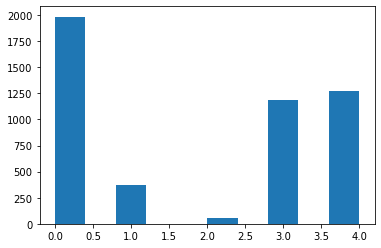

In [81]:
#Sets a random state so we get the same results every time
random_state = 170
#for now 
model = KMeans(n_clusters=5, random_state = random_state)
model.fit(train.to_numpy())
all_predictions = model.predict(train.to_numpy())
plt.hist(all_predictions)
len(all_predictions)

<p>The histogram shows the amount of songs in each category. We wanted to make our categories as distinct as possible, and worked hard to make sure they were populated relatively evenly.<br/><br/>
The cell below inserts the prediction group for each song in the dataframe.
</p>

In [82]:
#assigns the cluster number to the train dataframe for each corresponding song
song_info.drop(columns=['group'], inplace=True)
song_info.insert(len(song_info.columns), "group", all_predictions)

<p>This creates a class ‘Result’ which stores the necessary information from the ‘song_info’ and creates a list called ‘cluster’ with the information. TOM G EXPAND</p>

In [83]:
class Result:
    def __init__(self,peak, wc, wh, wth, inst, tail, group):
        self.peak = peak
        self.wc = wc
        self.wh = wh
        self.wth = wth
        self.inst = inst
        self.tail = tail
        self.group = group
        self.len = 1

    def add(self,peak, wc, wh, wth, inst, tail):
        self.peak += peak
        self.wc += wc
        self.wh += wh
        self.wth += wth
        self.inst += inst
        self.tail += tail
        self.len += 1

    def get_dict(self):
        return {
            'group' : self.group,
            "peak": self.peak / self.len,
            "weeks_on_chart": self.wc / self.len,
            'weeks_to_hot' : self.wth / self.len,
            "weeks_hot" : self.wh / self.len,
            'tail_weeks' : self.tail / self.len,
            'instance' : self.inst / self.len,
            'length' : self.len
        }


cluster = [-1] * 5
for i,r in song_info.iterrows():
    key = r.group
    if cluster[key] != -1:
        cluster[key].add(r.peak, r.weeks_on_chart, r.weeks_hot, r.weeks_to_hot, r.instance, r.tail_weeks)
    else:
        cluster[key] = Result(r.peak, r.weeks_on_chart, r.weeks_hot, r.weeks_to_hot, r.instance, r.tail_weeks, key)


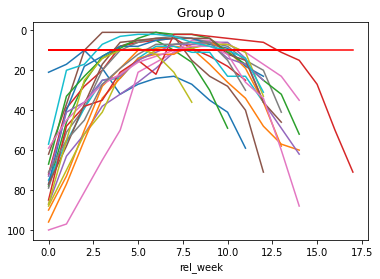

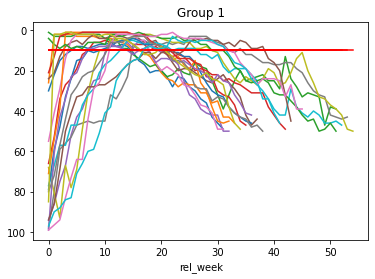

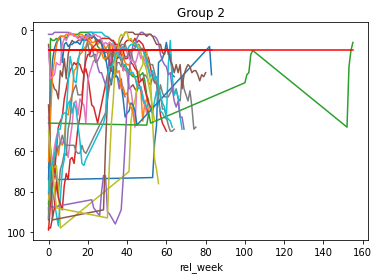

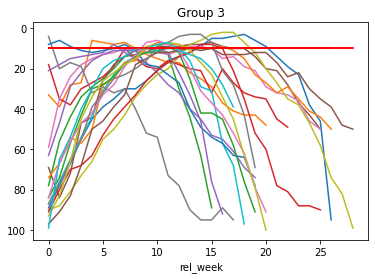

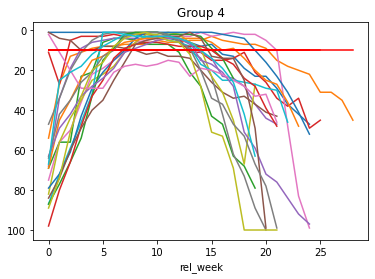

In [84]:
from random import sample
frames = {}
# fig, axs = plt.subplots(5,figsize=(20,15))
for c in sorted(cluster, key=lambda x: x.group):
    temp = song_info[song_info.group == c.group].index.values
    if len(temp) > 20:
        temp = sample(temp.tolist(),20)
    df = df.sort_values(by='week')
    ax = plt.gca()
    for s in temp:
        df[df.songid == s].plot(x='rel_week', y='week_position', ax=ax)
        horiz_line_data = np.array([10 for i in range(len(df[df.songid == s]))])
        plt.plot(df[df.songid == s].rel_week, horiz_line_data, 'r') 
    plt.gca().invert_yaxis()
    plt.gca().get_legend().remove()
    plt.title("Group " + str(c.group))
    plt.show()


In [85]:
clus_df = pd.DataFrame([c.get_dict() for c in cluster]).set_index('group')
clus_df

,peak,weeks_on_chart,weeks_to_hot,weeks_hot,tail_weeks,instance,length
group,,,,,,,
0,4.981351,13.799395,5.184476,4.672379,3.967742,1.005544,1984
1,3.639037,40.537433,10.417112,13.839572,17.112299,1.133690,374
2,4.019231,44.134615,52.826923,5.807692,13.365385,1.961538,52
3,7.127731,21.663025,10.315966,3.504202,8.189916,1.044538,1190
4,2.241352,23.049528,5.667453,9.774371,7.641509,1.011006,1272


<p>These are all the groups we found to be representative using K-Means. Each has its own distinct properties, as outlined above. This visual representation shows more clearly how each category differs from the others. Please note that it is important to notice the x-axis for each graph.</p>
<ol start="0">
<li>This group contains the most short-lived of the hits we analyzed. There is a short climb, short peak, and short tail. Some notable members of this group include Simon and Garfunkel's "Mrs. Robinson", The Beatles' "Help!", and Bobby Pickett's "Monster Mash". Many of these songs peaked high, but they dropped off the chart as quickly as they got on it. Unsurprisingly, this was by far the most populous of our groups, holding 1,984 distinct songs.</li>
<li>Group 1 is a set of much more long-lived hits. They have an average-length climb, but their peak and tail was by far the longest of the groups, showing that once the song hit its stride, it stayed on the charts for quite some time. Some notable members of this group are "7 Rings" by Ariana Grande, "Despacito" by Luis Fonsi, and "Sicko Mode" by Travis Scott. These are definitely the heavy hitters of the Billboard 100, averaging top peak at 3.63.</li>
<li>Group 2 was the most eclectic group, holding most of the outliers we came across. These songs took a long time to hit their stride, averaging 52 weeks to hit their peak. There were only 52 of these songs, proving this group's strange nature. Ironically, these songs sat on the chart for the longest, averaging 44 weeks in the top 100. "Shut Up and Dance" by Walk The Moon, "Radioactive" by Imagine Dragons, and "Rockstar" by Nickelback all populate this group.</li>
<li>Group 3 is another interesting group, representing songs which lived very shortly on the top of the charts. Similarly to group 0, they have a relatively short peak time. Group 3's mean peak time of 3.5 represents the shortest average time in the top 10 out of any category. Their climb length was aroung 10 weeks, similar to Group 1. However, they differed in their tail time. They fell from fame differently than groups 0 and 1, not lasting as long as Group 1 but not falling as quicly as Group 0. "Oops!...I Did It Again" by Britney Spears and "Sweet Home Alabama" by Lynyrd Skynyrd are both in this group.</li>
<li>Group 4 contains songs that had no trouble finding the top 10. Whether through hype, popularity of their artist, or viral trends, these songs skyrocketed to the top of the charts. They stayed there for an average amount of time, then fell off in a similar fashion. They weren't on the chart for an obscenely long time, but their mean peak of 2.2 shows they took control of the charts when they had their moment. Some popular songs in Group 4 include "I'm The One" by DJ Khaled, "Lean on Me" by Bill Withers, and "Owner Of A Lonely Heart" by Yes.</li>
</ol>
<p>All of these groups are very distinct, representing different types of hits that might appear on the Billboard 100. We can use our predictor to analyze any song we come across and accurately place it into one of these generated categories.</p>

In [86]:
song_info

,song,performer,peak,start_week,end_week,start_peak,end_peak,weeks_to_hot,weeks_hot,tail_weeks,time_at_top_10,climb_slope,tail_slope,avg_position,weeks_on_chart,instance,group
songid,,,,,,,,,,,,,,,,,
StillBill Anderson,Still,Bill Anderson,8.0,1963-04-13,1963-07-20,1963-06-08,1963-06-22,8.0,3.0,4.0,3.0,11.375000,7.000000,34.066667,15.0,1.0,0
Saturday NightBay City Rollers,Saturday Night,Bay City Rollers,1.0,1975-10-11,1976-01-31,1975-12-06,1976-01-10,8.0,6.0,3.0,6.0,9.500000,15.333333,27.588235,17.0,1.0,0
Pop MuzikM,Pop Muzik,M,1.0,1979-08-11,1980-01-19,1979-10-06,1979-12-01,8.0,9.0,7.0,9.0,6.625000,12.857143,25.208333,24.0,1.0,4
CarrieEurope,Carrie,Europe,3.0,1987-08-01,1987-12-05,1987-09-26,1987-10-24,8.0,5.0,6.0,5.0,8.125000,15.000000,35.736842,19.0,1.0,3
CasanovaLevert,Casanova,Levert,5.0,1987-08-15,1987-12-12,1987-10-10,1987-10-31,8.0,4.0,6.0,4.0,10.000000,15.166667,34.666667,18.0,1.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
You Keep Me Hangin' OnThe Supremes,You Keep Me Hangin' On,The Supremes,1.0,1966-10-29,1967-01-14,1966-11-12,1966-12-17,2.0,6.0,4.0,6.0,30.500000,11.250000,17.750000,12.0,1.0,0
You Keep Me Hangin' OnThe Vanilla Fudge,You Keep Me Hangin' On,The Vanilla Fudge,6.0,1967-07-08,1968-09-28,1968-08-31,1968-08-31,60.0,1.0,4.0,1.0,1.333333,4.250000,39.470588,17.0,2.0,2
You Learn/You Oughta KnowAlanis Morissette,You Learn/You Oughta Know,Alanis Morissette,6.0,1996-07-27,1997-02-15,1996-09-07,1996-09-28,6.0,4.0,20.0,7.0,0.666667,1.550000,22.433333,30.0,1.0,3


<h3 style="text-align: center;">Insights Attained</h3>

<p>As explained earlier, we can see from the prediction model that our hypothesis was mostly correct. Most songs were able to be categorized in groups using the KMeans clustering. From the graphs of each group above, most songs followed a similar pattern of the group that they were assigned to. However, the reason why we say that our hypothesis was “mostly correct” was because of the variations that occurred in some groups. For example, the clustering Group 8 was extremely good, with most results being close to each other in the life of the respective song. However, when looking at Group 4, we can notice an overall similar downward trend, but with more “noise” in the graph. And, for Group 1, we can see that there is only one song graphed. This is most likely because this song had no similar associations or categories as other groups. This song, PLACE SONG HERE, is an outlier in our scenario. For the most part, however, our hypothesis was correct and songs were able to be categorized. Using this prediction model, we can most likely figure out what category any song on the Billboard chart falls under. </p>

<h3 style="text-align: center;">Conclusion</h3>